In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
from helpers import style
from helpers.afa import adaptive_filter
from itertools import groupby
from tqdm import tqdm
from collections import Counter
from itertools import combinations
from collections import defaultdict
import networkx as nx
import random

from helpers.linkage import mutual_information_smooth
from helpers import nwsim
from helpers.metrics import *
from helpers.metrics import foote_novelty
import matplotlib.gridspec as gridspec

lda_path = '/home/rb/Documents/Data/models/lda/postwar-v3/'

style.load_style()

from helpers.dataloader import load

In [203]:
dists, dat, coltrans, keys = load(zscore_filter=False)

# Topic Linkage Network Similarity

The emergence of community structure is a sign of specialization. However, to what extent are communities stable over time?

In [204]:
from helpers.metrics import *

In [205]:
communities = {}
networks = {}

for cd,(date, _) in enumerate(dists.groupby(dists.index)):
    rij, ri, m = mutual_information_smooth(theta = _.to_numpy())
    rij = pd.DataFrame(rij, index=[keys[int(i)] for i in _.columns], columns=[keys[int(i)] for i in _.columns])
    rij = rij.stack().reset_index().rename(columns={"level_0":"s","level_1":"t",0:"pmi"})
    rij = rij[(rij.s != rij.t) & (rij.pmi > 0)]
    g = nx.from_pandas_edgelist(df = rij, source='s', target='t', edge_attr='pmi')
    cms = nx.algorithms.community.louvain_communities(g, weight='pmi',resolution=1.25)
    networks[str(date)] = g

    for cc,c in enumerate(cms):
        communities[f"{cd}-{cc}"] = c

In [206]:
r = [{"n1": ky1, "n2": ky2,'ovl':overlap_coefficient(c1,c2)}
     for ky1, c1 in communities.items() for ky2, c2 in communities.items() 
     if ky1 != ky2 and len(c1) > 3 and len(c2) > 3]

rd = pd.DataFrame(r)
rd = rd[(rd.n1.str.split('-').str[0].astype(int) + 1 == rd.n2.str.split('-').str[0].astype(int)) & (rd.ovl > .25)]
rd = rd.sort_values('ovl').drop_duplicates(['n1'], keep='last')

In [229]:
g = nx.from_pandas_edgelist(df = rd,source='n1',target='n2',create_using=nx.DiGraph(),edge_attr='ovl')

In [211]:
def filter_subpaths(list_,pb=False):
    non_subpaths = []

    if pb == True:
        for path in tqdm(list_):
            is_subpath = False
            for other_path in list_:
                if path != other_path and path in other_path:
                    is_subpath = True
                    break
            if not is_subpath:
                non_subpaths.append(path)
    else:
        for path in list_:
            is_subpath = False
            for other_path in list_:
                if path != other_path and path in other_path:
                    is_subpath = True
                    break
            if not is_subpath:
                non_subpaths.append(path)
    return non_subpaths

def chunk_list(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

def filter_subpaths_in_chunks(all_paths_str, chunk_size=1000, iterations=2):
    current_paths = all_paths_str

    for _ in range(iterations):
        intermediate_results = []
        for chunk in chunk_list(current_paths, chunk_size):
            filtered_chunk = filter_subpaths(chunk)
            intermediate_results.extend(filtered_chunk)
        random.shuffle(intermediate_results)
        current_paths = intermediate_results

    # Final filtering to ensure no subpaths exist in the final list
    final_results = filter_subpaths(current_paths)
    return final_results



# Use all_pairs_shortest_path to find all shortest paths between all pairs of nodes
paths_nx = dict(nx.all_pairs_shortest_path(g))

# Convert paths_nx to a list of paths
all_paths = [path for paths_from_source in paths_nx.values() for path in paths_from_source.values() if len(path) >= 8]
all_paths_str = ['_'.join(p) for p in all_paths]

In [212]:
filtered = filter_subpaths_in_chunks(all_paths_str, chunk_size=2000, iterations=6)

In [213]:
filtered = [f.split('_') for f in filtered]
cc =[{"c1":filtered.index(f1),"c2":filtered.index(f2),"s":overlap_coefficient(set(f1),set(f2))} for f1,f2 in list(combinations(filtered,2))]
cc = pd.DataFrame(cc)
cc = cc[(cc.c1 != cc.c2) & (cc.s > .75)]

tr =[]
for i,r in cc.iterrows():
    s1,s2 = len(filtered[int(r['c1'])]),len(filtered[int(r['c2'])])
    to_remove = r['c1'] if r['c1'] < r['c2'] else r['c2']
    tr.append(to_remove)

filtered = [f for c,f in enumerate(filtered) if c not in tr]
print(len(filtered))

25


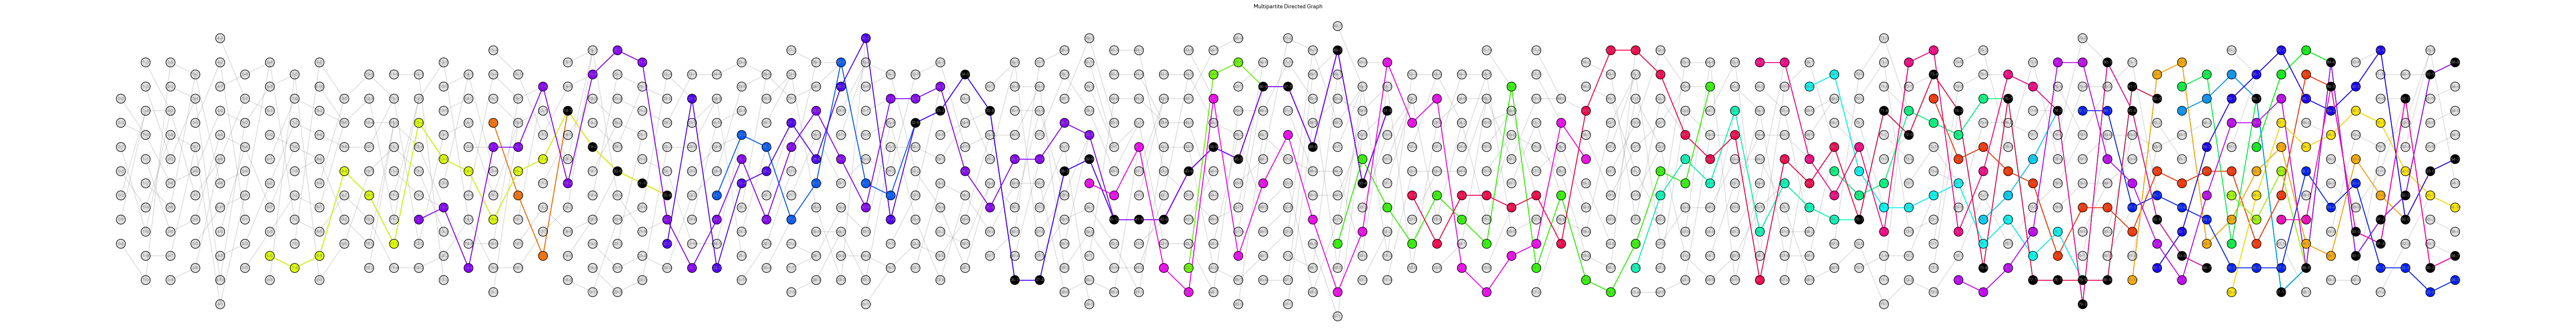

In [265]:
import seaborn as sns

# Initialize directed graph
G = nx.DiGraph()

# Add edges to the graph
for index, row in rd.iterrows():
    G.add_edge(row['n1'], row['n2'], weight=row['ovl'])

# Assign layers to nodes based on the prefix number before the '-'
layer_mapping = {node: int(node.split('-')[0]) for node in G.nodes}
for node, layer in layer_mapping.items():
    G.nodes[node]['layer'] = layer

# Create multipartite layout
pos = nx.multipartite_layout(G, subset_key='layer')

# Extract node and edge positions
x_nodes = [pos[node][0] for node in G.nodes]
y_nodes = [pos[node][1] for node in G.nodes]
edges = list(G.edges())
x_edges = [[pos[edge[0]][0], pos[edge[1]][0]] for edge in edges]
y_edges = [[pos[edge[0]][1], pos[edge[1]][1]] for edge in edges]

# Create a color palette
colors = sns.color_palette("hsv", len(filtered))

# Track node colors and chains
node_chain_count = {node: 0 for node in G.nodes}
node_colors = {node: (0.5, 0.5, 0.5, 0.25) for node in G.nodes}  # Default to gray with alpha 0.25
edge_alphas = {edge: 0.25 for edge in G.edges}

# Increment node count for each chain
for chain in filtered:
    for node in chain:
        if node in node_chain_count:
            node_chain_count[node] += 1

# Create subplots
fig, ax = plt.subplots(figsize=(80, 10))

# Highlight edges and nodes with unique colors for each chain
for idx, chain in enumerate(filtered):
    color = colors[idx % len(colors)]
    for i in range(len(chain) - 1):
        if G.has_edge(chain[i], chain[i+1]):
            ax.plot([pos[chain[i]][0], pos[chain[i+1]][0]], [pos[chain[i]][1], pos[chain[i+1]][1]], color=color, zorder=3)
            edge_alphas[(chain[i], chain[i+1])] = 1.0  # Set edge alpha to 1.0

    for node in chain:
        if node_chain_count[node] > 1:
            node_colors[node] = 'black'
        else:
            node_colors[node] = (*color, 1.0)  # Set node color with alpha 1.0

# Draw nodes with scatter
ax.scatter(x_nodes, y_nodes, s=250, c=[node_colors[node] for node in G.nodes], edgecolors='black', zorder=4)

# Draw edges with plot
for edge, alpha in edge_alphas.items():
    ax.plot([pos[edge[0]][0], pos[edge[1]][0]], [pos[edge[0]][1], pos[edge[1]][1]], color='gray', alpha=alpha, zorder=1)

# Draw labels with annotate
for node in G.nodes:
    ax.annotate(node, xy=pos[node], xytext=(0, 0), textcoords='offset points', fontsize=8, color='grey', ha='center', va='center',zorder=10)

# Set title
ax.set_title("Multipartite Directed Graph")

# Remove axis
ax.axis('off')

# Show plot
plt.savefig('/home/rb/Desktop/test.pdf')
plt.show()

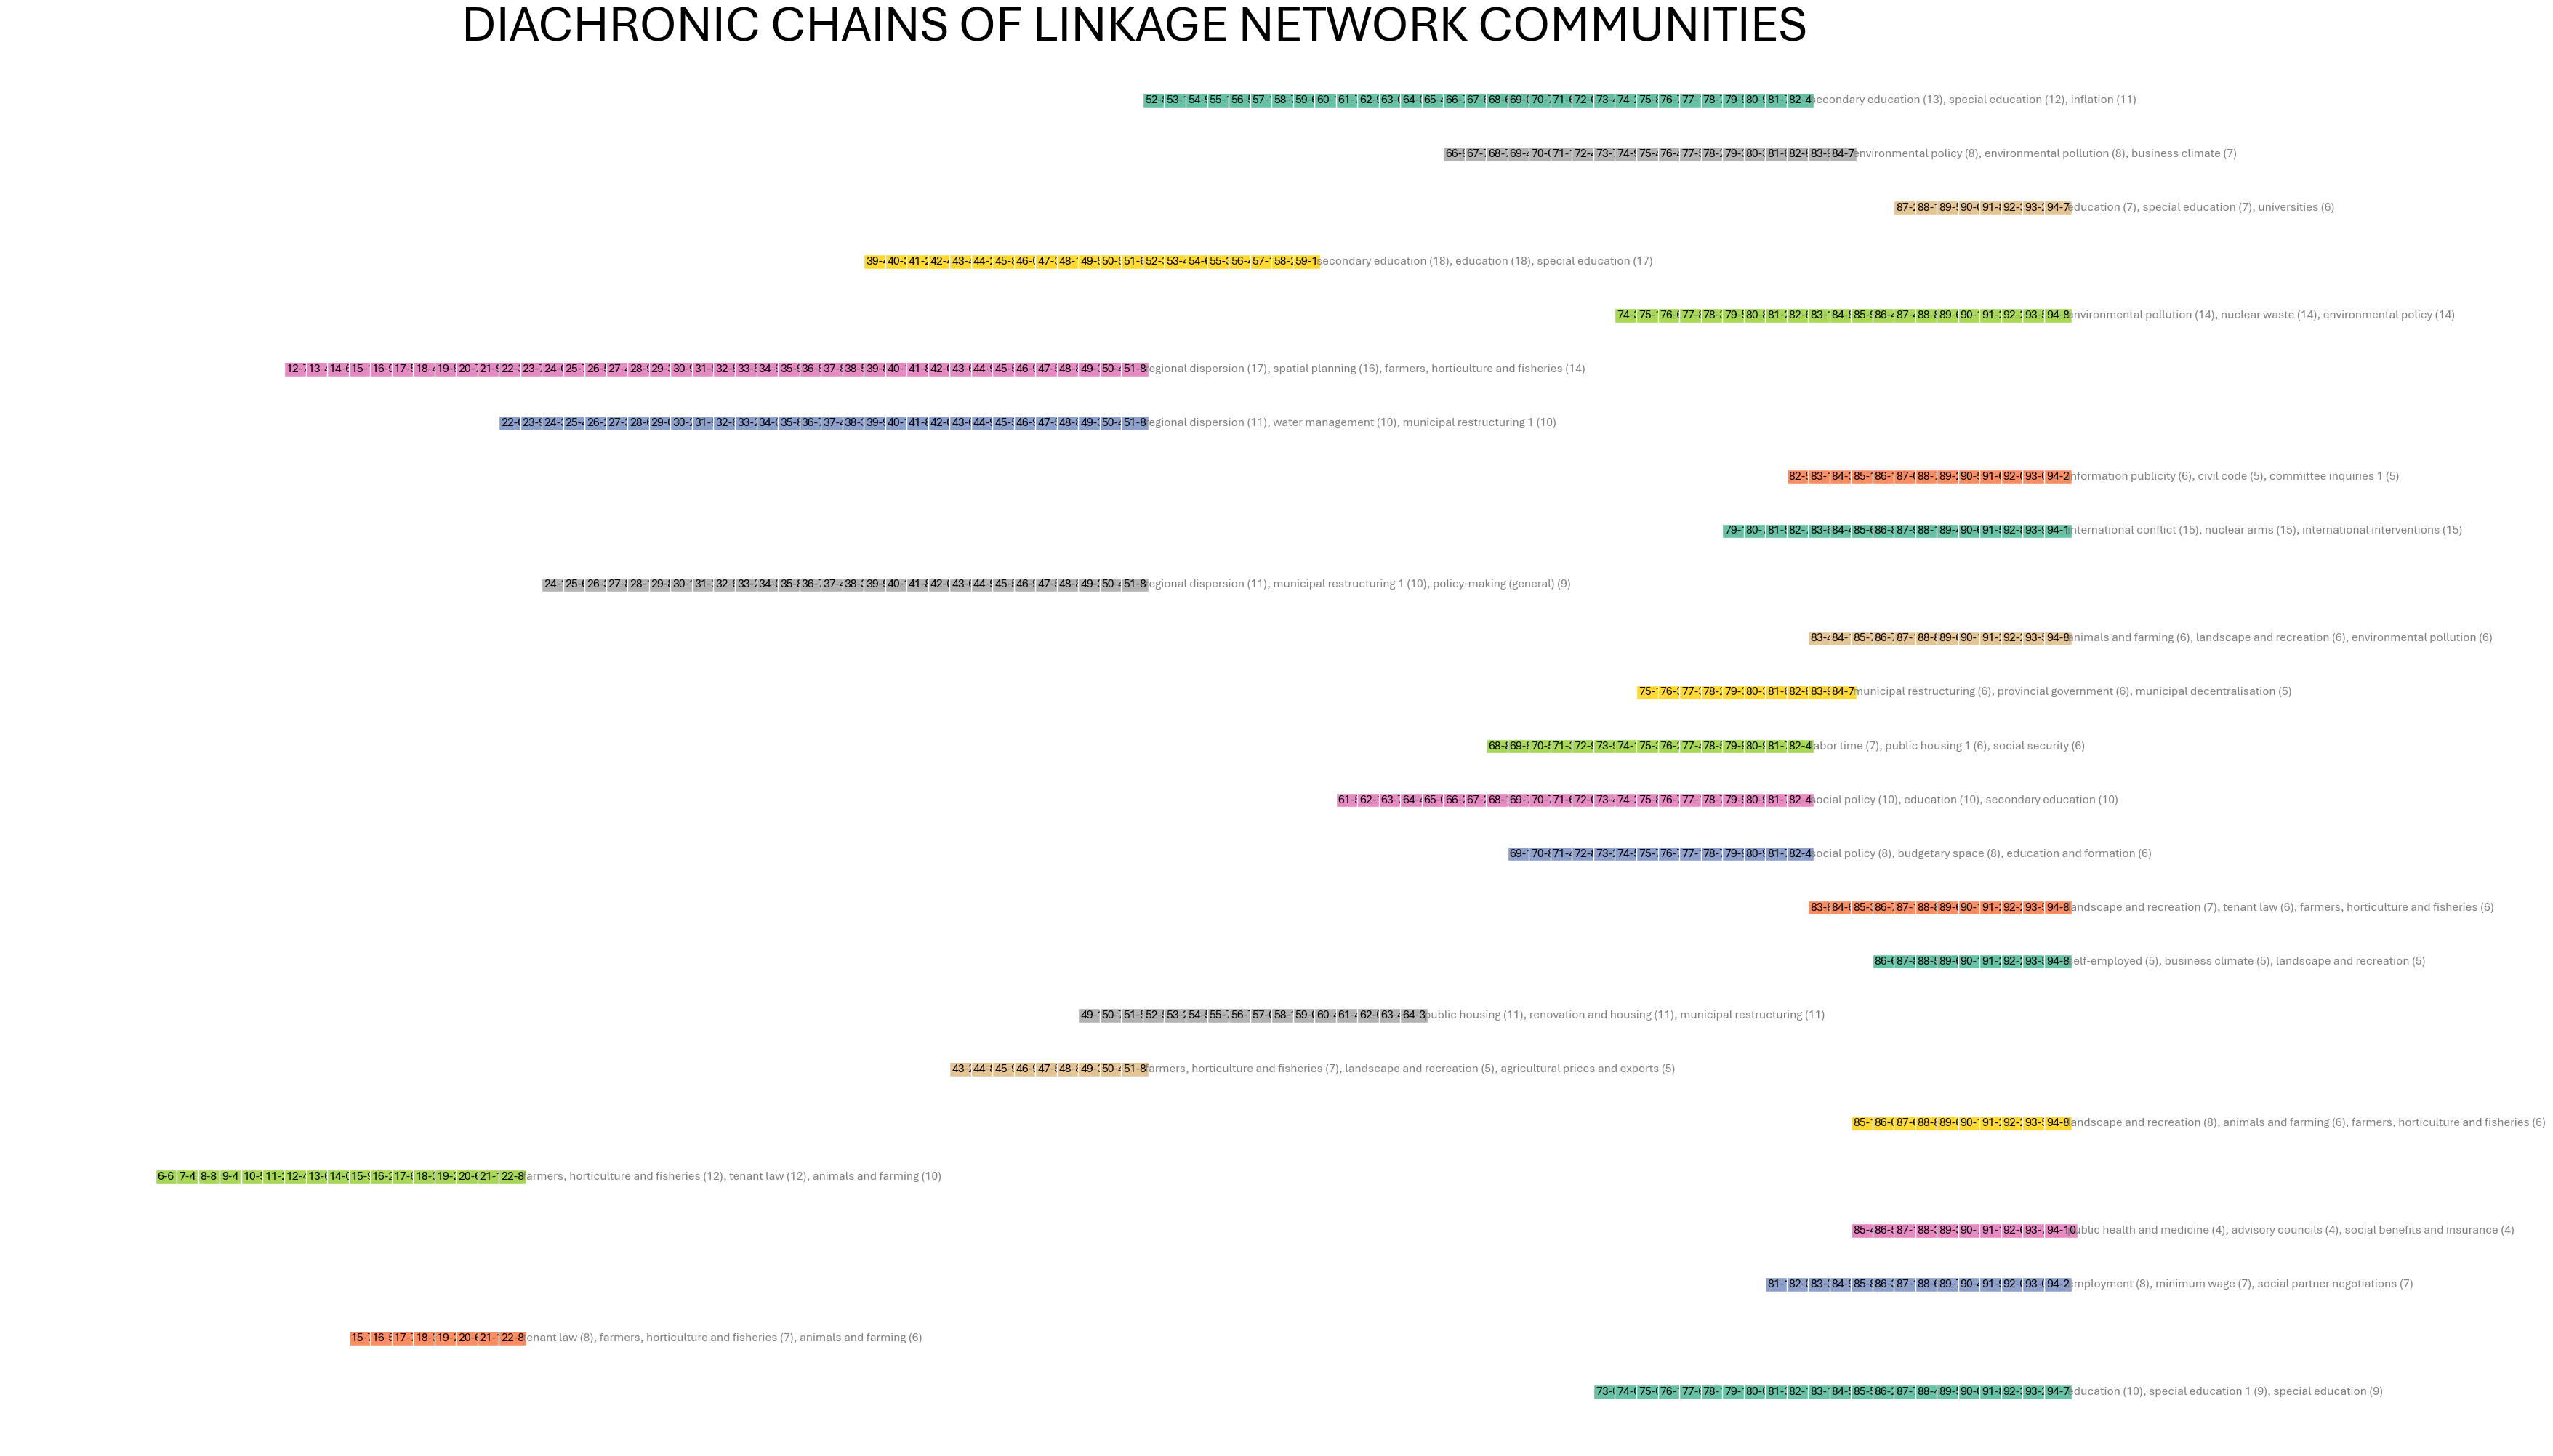

In [214]:
f, a = plt.subplots(figsize=(40,25))

cmap = sns.color_palette('Set2',len(filtered))

for ylevel,chain in enumerate(filtered):

    topics = []
    for node in chain:
        x = int(node.split('-')[0])
        a.annotate(text=node,xy=(x,ylevel),color='black',bbox=dict(facecolor=cmap[ylevel], edgecolor='white', pad=2.0))
        topics += list(communities[node])
    topics = ', '.join([f"{t} ({c})" for t,c in Counter(topics).most_common(3)])
    a.annotate(text=topics,xy=(x + 1,ylevel),color='grey')

a.set_xlim(-1,104)
a.set_ylim(-1,ylevel+1)
a.axis('off')
a.set_title('Diachronic Chains of Linkage Network Communities'.upper(),fontsize=50)
# explanation = """The first number in the node refers to the period, the second to the community ID in that period\nClusters are linked if they have a Jaccard Similarity of > .25\nFor every cluster in period P, its top match in period P+1 is identified.\nAfter the last cluster in the chain, the most frequent topics in the chain are shown."""
# a.annotate(text=explanation,xy=(-.5,2.5),color='black',bbox=dict(facecolor="whitesmoke", edgecolor='black', pad=10.0),fontsize=20)
plt.savefig('/home/rb/Desktop/cluster-chains.pdf',dpi=350)
plt.show()

In [275]:
topics_in_chains = []

for c in filtered:
    for co in c:
        period = co.split('-')[0]
        for t in communities[co]:
            
            topics_in_chains.append({"period":period,"topic":t})

<AxesSubplot: xlabel='period'>

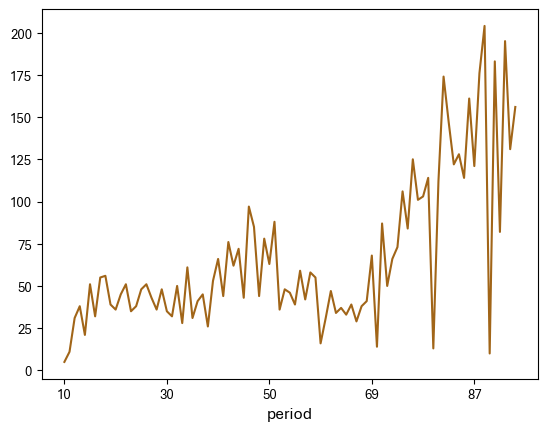

In [278]:
pd.DataFrame(topics_in_chains).groupby('period').size().plot()